# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Escreva um Algoritmo para um Aplicativo de Identificação de Cães 

---

Neste caderno, alguns códigos de modelo já foram fornecidos para você e você precisará implementar funcionalidades adicionais para concluir com êxito este projeto. Você não precisará modificar o código incluído além do que é solicitado. As seções que começam com ** '(IMPLEMENTATION)' ** no cabeçalho indicam que o seguinte bloco de código exigirá uma funcionalidade adicional que você deve fornecer. Serão fornecidas instruções para cada seção e as especificidades da implementação serão marcadas no bloco de códigos com uma instrução 'TODO'. Por favor, leia atentamente as instruções! 

> **Note**:Depois de concluir todas as implementações de código, você precisa finalizar seu trabalho exportando o iPython Notebook como um documento HTML. Antes de exportar o bloco de anotações para html, todas as células de código precisam ter sido executadas para que os revisores possam ver a implementação e a saída final. Você pode exportar o notebook usando o menu acima e navegando para \ n ",
    "**File -> Download as -> HTML (.html)**. Inclua o documento final junto com este caderno como sua submissão.

Além de implementar o código, haverá perguntas que você deve responder relacionadas ao projeto e à sua implementação. Cada seção onde você responderá uma questão é precedida por um cabeçalho ** 'Question X' **. Leia atentamente cada pergunta e forneça respostas completas nas seguintes caixas de texto que começam com ** 'Resposta:' **. A submissão do seu projeto será avaliada com base nas suas respostas para cada uma das perguntas e na implementação que você fornecer.

>**Note:** As células Code e Markdown podem ser executadas usando o atalho de teclado ** Shift + Enter **. As células Markdown podem ser editadas clicando duas vezes na célula para entrar no modo de edição.

A rubrica contém _opcional_ "Sugestões de destaque" para aprimorar o projeto além dos requisitos mínimos. Se você decidir seguir as "Sugestões de destaque", inclua o código neste bloco de notas do IPython.

---
### Por que estamos aqui?

Neste caderno, você dará os primeiros passos para desenvolver um algoritmo que possa ser usado como parte de um aplicativo móvel ou da web. No final deste projeto, seu código aceitará qualquer imagem fornecida pelo usuário como entrada. Se um cachorro for detectado na imagem, ele fornecerá uma estimativa da raça do cão. Se um ser humano for detectado, ele fornecerá uma estimativa da raça do cão que mais se parece. A imagem abaixo mostra a saída de amostra potencial do seu projeto finalizado (... mas esperamos que o algoritmo de cada aluno se comporte de maneira diferente!). 

![Sample Dog Output](images/sample_dog_output.png)

Neste cenário do mundo real, você precisará juntar uma série de modelos para realizar diferentes tarefas; por exemplo, o algoritmo que detecta humanos em uma imagem será diferente da CNN que infere a raça do cão. Existem muitos pontos de possíveis falhas e nenhum algoritmo perfeito existe. Sua solução imperfeita, no entanto, criará uma experiência de usuário divertida!

### A estrada adiante

Nós quebramos o notebook em etapas separadas. Sinta-se à vontade para usar os links abaixo para navegar no notebook.

* [Step 0](#step0): Importar conjunto de dados
* [Step 1](#step1): Detectar Humanos
* [Step 2](#step2): Detectar Cachorros
* [Step 3](#step3): Crie uma CNN para classificar as raças de cães (do zero)
* [Step 4](#step4): Use uma CNN para Classificar Raças de Cães (usando o Aprendizado de Transferência)
* [Step 5](#step5): Crie uma CNN para Classificar Raças de Cães (usando Transfer Learning)
* [Step 6](#step6): Escreva seu Algoritmo
* [Step 7](#step7): Teste seu algoritmo

---
<a id='step0'></a>
## Passo 0: Importar Bases de Dados

### Importar base de dados de cachorros

Na célula de código abaixo, importamos um conjunto de dados de imagens de cachorros. Nós preenchemos algumas variáveis através do uso da função `load_files` da biblioteca scikit-learn:
- `train_files`, `valid_files`, `test_files` - numpy arrays contendo caminhos de arquivos para imagens
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays contendo rótulos de classificação codificados 
- `dog_names` - lista de nomes de raças de cães com valor de string para traduzir rótulos

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Importar Conjunto de Dados Humanos

Na célula de código abaixo, nós importamos um conjunto de dados de imagens humanas, onde os caminhos de arquivo são armazenados no array numpy `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detectando Humanos

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

Na próxima célula de código, demonstramos como usar esse detector para encontrar rostos humanos em uma imagem de amostra.

Number of faces detected: 1


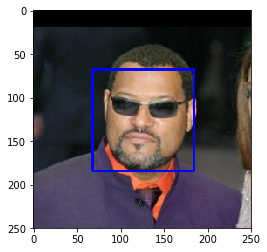

In [49]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Antes de usar qualquer um dos detectores de face, é procedimento padrão converter as imagens em tons de cinza. A função `detectMultiScale` executa o classificador armazenado em` face_cascade` e pega a imagem em tons de cinza como um parâmetro.

No código acima, `faces` é um array numpy de faces detectadas, onde cada linha corresponde a uma face detectada. Cada face detectada é uma matriz 1D com quatro entradas que especifica a caixa delimitadora da face detectada. As duas primeiras entradas na matriz (extraídas no código acima como `x` e` y`) especificam as posições horizontal e vertical do canto superior esquerdo da caixa delimitadora. As duas últimas entradas na matriz (extraídas aqui como `w` e` h`) especificam a largura e a altura da caixa.

### Escreva um Detector de Rosto Humano

Podemos usar este procedimento para escrever uma função que retorne `True` se um rosto humano for detectado em uma imagem e` False` caso contrário. Esta função, apropriadamente chamada `face_detector`, leva um caminho de arquivo com valor de string para uma imagem como entrada e aparece no bloco de código abaixo.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTAÇÃO) Avaliar o detector de rosto humano


__Questão 1:__ Use a célula de código abaixo para testar o desempenho da função `face_detector`.  
- Qual porcentagem das primeiras 100 imagens em `human_files` possui um rosto humano detectado? 
- Qual porcentagem das primeiras 100 imagens em `dog_files` tem um rosto humano detectado? 

Idealmente, gostaríamos de 100% das imagens humanas com um rosto detectado e 0% de imagens de cães com um rosto detectado. Você verá que nosso algoritmo está aquém desse objetivo, mas ainda oferece um desempenho aceitável. Nós extraímos os caminhos dos arquivos das primeiras 100 imagens de cada um dos conjuntos de dados e os armazenamos nas matrizes numpy `human_files_short` e` dog_files_short`.

__Resposta:__ 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
humanInHumans = np.sum([face_detector(i) for i in human_files_short])
humanInDogs = np.sum([face_detector(i) for i in dog_files_short])
print("%d das primeiras 100 imagens em human_files têm um rosto humano detectado" % humanInHumans)
print("%d das primeiras 100 imagens em dog_files têm um rosto humano detectado" % humanInDogs)

99 das primeiras 100 imagens em human_files têm um rosto humano detectado
12 das primeiras 100 imagens em dog_files têm um rosto humano detectado


__Questão 2:__ Essa escolha algorítmica exige que comuniquemos ao usuário que aceitamos imagens humanas apenas quando elas fornecem uma visão clara de um rosto (caso contrário, corremos o risco de ter usuários frustrados desnecessariamente!). Na sua opinião, isso é uma expectativa razoável para o usuário? Se não, você pode pensar em uma maneira de detectar humanos em imagens que não necessitem de uma imagem com um rosto claramente apresentado?

__Reposta:__

Sugerimos o detector de rosto do OpenCV como uma maneira potencial de detectar imagens humanas em seu algoritmo, mas você está livre para explorar outras abordagens, especialmente abordagens que fazem uso do aprendizado profundo :). Por favor, use a célula de código abaixo para projetar e testar seu próprio algoritmo de detecção de rosto. Se você decidir prosseguir com essa tarefa _opcional_, relate o desempenho em cada um dos conjuntos de dados.

In [ ]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Etapa 2: Detectar Cães

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

Ao usar o TensorFlow como backend, os CNNs da Keras requerem uma matriz 4D (a qual também nos referimos como um tensor 4D) como entrada, com forma

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

Onde `nb_samples` corresponde ao número total de imagens (ou amostras), e` rows`, `columns` e` channels` correspondem ao número de linhas, colunas e canais para cada imagem, respectivamente. 

A função `path_to_tensor` abaixo usa um caminho de arquivo com valor de string para uma imagem colorida como entrada e retorna um tensor de 4D adequado para o fornecimento a uma CNN de Keras. A função primeiro carrega a imagem e a redimensiona para uma imagem quadrada que é 224 \ x 224 $ pixels. Em seguida, a imagem é convertida em uma matriz, que é então redimensionada para um tensor 4D. Nesse caso, como estamos trabalhando com imagens coloridas, cada imagem tem três canais. Da mesma forma, como estamos processando uma única imagem (ou amostra), o tensor retornado sempre terá forma

$$
(1, 224, 224, 3).
$$

A função `paths_to_tensor` usa uma matriz numpy de caminhos de imagem com valor de string como entrada e retorna um tensor 4D com forma

$$
(\text{nb_samples}, 224, 224, 3).
$$

Aqui, `nb_samples` é o número de amostras, ou número de imagens, na matriz fornecida de caminhos de imagem. É melhor pensar em `nb_samples` como o número de tensores 3D (em que cada tensor 3D corresponde a uma imagem diferente) em seu conjunto de dados!

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Fazendo previsões com o ResNet-50

Preparar o tensor 4D para o ResNet-50 e para qualquer outro modelo pré-treinado em Keras requer algum processamento adicional. Primeiro, a imagem RGB é convertida em BGR, reordenando os canais. Todos os modelos pré-treinados têm o passo de normalização adicional de que o pixel médio (expresso em RGB como $ [103.939, 116.779, 123.68] $ e calculado a partir de todos os pixels em todas as imagens no ImageNet) deve ser subtraído de cada pixel em cada imagem. Isso é implementado na função importada `preprocess_input`. Se você está curioso, você pode verificar o código para `preprocess_input` [aqui](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Agora que temos uma maneira de formatar nossa imagem para fornecer para a ResNet-50, agora estamos prontos para usar o modelo para extrair as previsões. Isso é realizado com o método `predict`, que retorna um array cuja entrada $ i $ -th é a probabilidade prevista do modelo de que a imagem pertence à categoria $ i $ -th ImageNet. Isso é implementado na função `ResNet50_predict_labels` abaixo.

Tomando o argmax do vetor de probabilidade previsto, obtemos um número inteiro correspondente à classe de objeto prevista do modelo, que podemos identificar com uma categoria de objeto através do uso dessa classe. [dicionário](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Escreva um Detector de Cachorros

Enquanto olha para o [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), você notará que as categorias correspondentes aos cães aparecem em uma sequência ininterrupta e correspondem às chaves do dicionário 151-268, inclusive, para incluir todas as categorias de "Chihuahua" a "Mexican hairless". Assim, para verificar se uma imagem está prevista para conter um cão pelo modelo ResNet-50 pré-treinado, precisamos apenas verificar se a função `ResNet50_predict_labels` acima retorna um valor entre 151 e 268 (inclusive).

Usamos essas idéias para completar a função `dog_detector` abaixo, que retorna` True` se um cachorro for detectado em uma imagem (e `False` se não for).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTAÇÃO) Avaliar o Detector de Cachorros

__Questão 3:__ Use a célula de código abaixo para testar o desempenho da sua função `dog_detector`.  
- Qual porcentagem das imagens em `human_files_short` tem um cachorro detectado?  
- Qual porcentagem das imagens em `dog_files_short` tem um cachorro detectado?

__Resposta:__ 

In [10]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short
dogInHumans = np.sum([dog_detector(img) for img in human_files_short])
dogInDogs = np.sum([dog_detector(img) for img in dog_files_short])
print("%d das imagens em human_files_short tem um cão detectado." % dogInHumans)
print("%d as imagens em dog_files_short tem um cão detectado." % dogInDogs)

1 das imagens em human_files_short tem um cão detectado.
100 as imagens em dog_files_short tem um cão detectado.


---
<a id='step3'></a>
## Etapa 3: Criar uma CNN para classificar as raças de cães (do zero)

Agora que temos funções para detectar humanos e cães em imagens, precisamos prever uma raça a partir de imagens. Nesta etapa, você criará uma CNN que classifica as raças de cães. Você deve criar sua CNN _from_stype_ (assim, você não pode usar a aprendizagem de transferência _yet_!), E você deve atingir uma precisão de teste de pelo menos 1%. Na Etapa 5 deste caderno, você terá a oportunidade de usar o aprendizado de transferência para criar uma CNN que atinja uma precisão muito melhor.

Tenha cuidado ao adicionar muitas camadas treináveis! Mais parâmetros significam um treinamento mais longo, o que significa que é mais provável que você precise de uma GPU para acelerar o processo de treinamento. Felizmente, Keras fornece uma estimativa útil do tempo que cada época provavelmente terá; Você pode extrapolar essa estimativa para descobrir quanto tempo levará para o seu algoritmo treinar.

Mencionamos que a tarefa de designar raça aos cães a partir de imagens é considerada excepcionalmente desafiadora. Para ver por que, considere que * até mesmo um humano * teria grande dificuldade em distinguir entre um Brittany e um Welsh Springer Spaniel.  
Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

Não é difícil encontrar outros pares de raças de cães com variação interclasses mínima (por exemplo, Retrievers Coated e American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">

Da mesma forma, lembre-se de que os labradores vêm em amarelo, chocolate e preto. Seu algoritmo baseado em visão terá que conquistar essa alta variação intraclasse para determinar como classificar todos esses diferentes tons como a mesma raça.

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

Também mencionamos que a chance aleatória apresenta uma barra excepcionalmente baixa: deixando de lado o fato de que as classes são ligeiramente equilibradas, um palpite aleatório fornecerá uma resposta correta de aproximadamente 1 em 133 vezes, o que corresponde a uma precisão de menos de 1%.

Lembre-se de que a prática está muito à frente da teoria em aprendizado profundo. Experimente várias arquiteturas diferentes e confie na sua intuição. E, claro, divirta-se! 

### Pré-processar os dados

Nós redimensionamos as imagens dividindo cada pixel em cada imagem por 255.

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████████████████████████████████████████████| 836/836 [01:29<00:00,  9.34it/s]


### (IMPLEMENTAÇÃO) Arquitetura do modelo

Crie uma CNN para classificar a raça do cão. No final do seu bloco de células de código, resuma as camadas do seu modelo executando a linha:
    
        model.summary()

Nós importamos alguns módulos Python para você começar, mas fique à vontade para importar quantos módulos precisar. Se você acabar ficando preso, aqui vai uma dica que especifica um modelo que treina relativamente rápido na CPU e atinge precisão de teste de > 1% em 5 épocas:

![Sample CNN](images/sample_cnn.png)
           
__Questão 4:__ Descreva os passos que você deu para chegar à arquitetura final da CNN e seu raciocínio em cada etapa. Se você escolheu usar a arquitetura sugerida acima, descreva por que você acha que a arquitetura CNN deve funcionar bem para a tarefa de classificação de imagens.

__Resposta:__ 

In [12]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model = Sequential()
model.add(Conv2D(32,(3, 3),activation='relu',input_shape=train_tensors[0].shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 53, 53, 128)       73856     
__________

### Compile the Model

In [13]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTAÇÃO) Treine o Modelo

Treine seu modelo na célula de código abaixo. Use o checkpointing de modelo para salvar o modelo que atinge a melhor perda de validação.

Você é bem vindo para [aumentar os dados de treinamento](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), mas isso não é um requisito.
 

In [17]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 7

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/7


4060/6680 [=================>............] - ETA: 10:42 - loss: 4.8451 - acc: 0.0000e+ - ETA: 10:12 - loss: 4.8695 - acc: 0.0250   - ETA: 9:57 - loss: 4.8736 - acc: 0.0167 - ETA: 10:10 - loss: 4.8569 - acc: 0.02 - ETA: 10:23 - loss: 4.8778 - acc: 0.02 - ETA: 10:17 - loss: 4.8805 - acc: 0.01 - ETA: 10:17 - loss: 4.8783 - acc: 0.01 - ETA: 10:17 - loss: 4.8770 - acc: 0.01 - ETA: 10:11 - loss: 4.8707 - acc: 0.01 - ETA: 10:08 - loss: 4.8697 - acc: 0.01 - ETA: 10:08 - loss: 4.8667 - acc: 0.00 - ETA: 10:08 - loss: 4.8655 - acc: 0.00 - ETA: 10:04 - loss: 4.8675 - acc: 0.00 - ETA: 10:02 - loss: 4.8673 - acc: 0.00 - ETA: 10:00 - loss: 4.8654 - acc: 0.00 - ETA: 9:58 - loss: 4.8684 - acc: 0.0063 - ETA: 9:58 - loss: 4.8695 - acc: 0.005 - ETA: 9:56 - loss: 4.8679 - acc: 0.005 - ETA: 9:51 - loss: 4.8615 - acc: 0.010 - ETA: 9:47 - loss: 4.8590 - acc: 0.010 - ETA: 9:44 - loss: 4.8574 - acc: 0.009 - ETA: 9:42 - loss: 4.8474 - acc: 0.009 - ETA: 9:40 - loss: 4.8460 - acc: 0.010 - ETA: 9:37 - loss: 4.8442 

6660/6680 [============================>.] - ETA: 4:00 - loss: 4.8230 - acc: 0.015 - ETA: 3:58 - loss: 4.8231 - acc: 0.015 - ETA: 3:56 - loss: 4.8230 - acc: 0.015 - ETA: 3:54 - loss: 4.8230 - acc: 0.015 - ETA: 3:52 - loss: 4.8225 - acc: 0.015 - ETA: 3:50 - loss: 4.8232 - acc: 0.015 - ETA: 3:48 - loss: 4.8232 - acc: 0.016 - ETA: 3:46 - loss: 4.8226 - acc: 0.016 - ETA: 3:45 - loss: 4.8223 - acc: 0.016 - ETA: 3:43 - loss: 4.8217 - acc: 0.017 - ETA: 3:41 - loss: 4.8215 - acc: 0.017 - ETA: 3:39 - loss: 4.8208 - acc: 0.017 - ETA: 3:37 - loss: 4.8218 - acc: 0.017 - ETA: 3:35 - loss: 4.8215 - acc: 0.017 - ETA: 3:33 - loss: 4.8208 - acc: 0.017 - ETA: 3:31 - loss: 4.8201 - acc: 0.017 - ETA: 3:29 - loss: 4.8203 - acc: 0.017 - ETA: 3:27 - loss: 4.8191 - acc: 0.017 - ETA: 3:26 - loss: 4.8173 - acc: 0.018 - ETA: 3:24 - loss: 4.8167 - acc: 0.017 - ETA: 3:22 - loss: 4.8185 - acc: 0.017 - ETA: 3:20 - loss: 4.8185 - acc: 0.017 - ETA: 3:18 - loss: 4.8174 - acc: 0.018 - ETA: 3:16 - loss: 4.8176 - acc: 0.0

4060/6680 [=================>............] - ETA: 10:27 - loss: 4.6958 - acc: 0.0000e+ - ETA: 10:23 - loss: 4.6434 - acc: 0.0000e+ - ETA: 10:26 - loss: 4.7273 - acc: 0.0000e+ - ETA: 10:26 - loss: 4.7244 - acc: 0.0000e+ - ETA: 10:25 - loss: 4.7012 - acc: 0.0000e+ - ETA: 10:24 - loss: 4.6922 - acc: 0.0000e+ - ETA: 10:22 - loss: 4.6755 - acc: 0.0000e+ - ETA: 10:21 - loss: 4.6550 - acc: 0.0063   - ETA: 10:17 - loss: 4.6476 - acc: 0.01 - ETA: 10:09 - loss: 4.6575 - acc: 0.02 - ETA: 10:02 - loss: 4.6346 - acc: 0.02 - ETA: 9:56 - loss: 4.6278 - acc: 0.0250 - ETA: 9:51 - loss: 4.6217 - acc: 0.026 - ETA: 9:47 - loss: 4.6262 - acc: 0.025 - ETA: 9:43 - loss: 4.6264 - acc: 0.026 - ETA: 9:39 - loss: 4.6156 - acc: 0.031 - ETA: 9:35 - loss: 4.6228 - acc: 0.029 - ETA: 9:32 - loss: 4.6237 - acc: 0.027 - ETA: 9:29 - loss: 4.6366 - acc: 0.026 - ETA: 9:25 - loss: 4.6370 - acc: 0.025 - ETA: 9:23 - loss: 4.6280 - acc: 0.023 - ETA: 9:22 - loss: 4.6309 - acc: 0.022 - ETA: 9:20 - loss: 4.6217 - acc: 0.021 - ET

6660/6680 [============================>.] - ETA: 3:53 - loss: 4.5488 - acc: 0.034 - ETA: 3:51 - loss: 4.5489 - acc: 0.034 - ETA: 3:49 - loss: 4.5499 - acc: 0.034 - ETA: 3:47 - loss: 4.5500 - acc: 0.034 - ETA: 3:46 - loss: 4.5506 - acc: 0.034 - ETA: 3:44 - loss: 4.5493 - acc: 0.034 - ETA: 3:42 - loss: 4.5483 - acc: 0.034 - ETA: 3:40 - loss: 4.5479 - acc: 0.034 - ETA: 3:38 - loss: 4.5479 - acc: 0.034 - ETA: 3:37 - loss: 4.5473 - acc: 0.034 - ETA: 3:35 - loss: 4.5477 - acc: 0.034 - ETA: 3:33 - loss: 4.5480 - acc: 0.034 - ETA: 3:31 - loss: 4.5478 - acc: 0.034 - ETA: 3:29 - loss: 4.5470 - acc: 0.034 - ETA: 3:27 - loss: 4.5472 - acc: 0.034 - ETA: 3:26 - loss: 4.5461 - acc: 0.034 - ETA: 3:24 - loss: 4.5455 - acc: 0.034 - ETA: 3:22 - loss: 4.5448 - acc: 0.034 - ETA: 3:20 - loss: 4.5445 - acc: 0.034 - ETA: 3:18 - loss: 4.5427 - acc: 0.034 - ETA: 3:17 - loss: 4.5432 - acc: 0.034 - ETA: 3:15 - loss: 4.5427 - acc: 0.034 - ETA: 3:13 - loss: 4.5421 - acc: 0.034 - ETA: 3:11 - loss: 4.5435 - acc: 0.0

4080/6680 [=================>............] - ETA: 10:17 - loss: 4.0279 - acc: 0.10 - ETA: 10:08 - loss: 4.1546 - acc: 0.05 - ETA: 9:59 - loss: 4.2325 - acc: 0.0500 - ETA: 9:49 - loss: 4.2809 - acc: 0.050 - ETA: 9:44 - loss: 4.3519 - acc: 0.050 - ETA: 9:44 - loss: 4.3714 - acc: 0.050 - ETA: 9:43 - loss: 4.4024 - acc: 0.042 - ETA: 9:37 - loss: 4.3879 - acc: 0.056 - ETA: 9:30 - loss: 4.4204 - acc: 0.061 - ETA: 9:25 - loss: 4.4262 - acc: 0.055 - ETA: 9:23 - loss: 4.4290 - acc: 0.059 - ETA: 9:19 - loss: 4.4029 - acc: 0.058 - ETA: 9:16 - loss: 4.3840 - acc: 0.057 - ETA: 9:13 - loss: 4.3908 - acc: 0.057 - ETA: 9:09 - loss: 4.3868 - acc: 0.060 - ETA: 9:06 - loss: 4.3831 - acc: 0.065 - ETA: 9:04 - loss: 4.3792 - acc: 0.067 - ETA: 9:01 - loss: 4.3906 - acc: 0.063 - ETA: 8:59 - loss: 4.3848 - acc: 0.063 - ETA: 8:57 - loss: 4.3917 - acc: 0.067 - ETA: 8:55 - loss: 4.3941 - acc: 0.066 - ETA: 8:53 - loss: 4.4014 - acc: 0.063 - ETA: 8:51 - loss: 4.4014 - acc: 0.060 - ETA: 8:49 - loss: 4.4075 - acc: 0.

6660/6680 [============================>.] - ETA: 3:48 - loss: 4.3310 - acc: 0.062 - ETA: 3:47 - loss: 4.3308 - acc: 0.061 - ETA: 3:45 - loss: 4.3291 - acc: 0.062 - ETA: 3:43 - loss: 4.3285 - acc: 0.062 - ETA: 3:41 - loss: 4.3298 - acc: 0.062 - ETA: 3:39 - loss: 4.3315 - acc: 0.062 - ETA: 3:38 - loss: 4.3313 - acc: 0.062 - ETA: 3:36 - loss: 4.3297 - acc: 0.062 - ETA: 3:34 - loss: 4.3297 - acc: 0.062 - ETA: 3:32 - loss: 4.3293 - acc: 0.062 - ETA: 3:31 - loss: 4.3295 - acc: 0.062 - ETA: 3:29 - loss: 4.3304 - acc: 0.062 - ETA: 3:27 - loss: 4.3306 - acc: 0.062 - ETA: 3:25 - loss: 4.3294 - acc: 0.062 - ETA: 3:23 - loss: 4.3299 - acc: 0.062 - ETA: 3:22 - loss: 4.3305 - acc: 0.061 - ETA: 3:20 - loss: 4.3308 - acc: 0.061 - ETA: 3:18 - loss: 4.3309 - acc: 0.061 - ETA: 3:16 - loss: 4.3318 - acc: 0.061 - ETA: 3:14 - loss: 4.3304 - acc: 0.061 - ETA: 3:13 - loss: 4.3298 - acc: 0.061 - ETA: 3:11 - loss: 4.3302 - acc: 0.061 - ETA: 3:09 - loss: 4.3298 - acc: 0.061 - ETA: 3:07 - loss: 4.3310 - acc: 0.0

4080/6680 [=================>............] - ETA: 9:51 - loss: 4.2027 - acc: 0.100 - ETA: 9:54 - loss: 4.1358 - acc: 0.125 - ETA: 9:47 - loss: 4.1752 - acc: 0.083 - ETA: 9:46 - loss: 4.1157 - acc: 0.075 - ETA: 9:47 - loss: 4.1522 - acc: 0.080 - ETA: 9:43 - loss: 4.0966 - acc: 0.100 - ETA: 9:42 - loss: 4.1333 - acc: 0.085 - ETA: 9:40 - loss: 4.1462 - acc: 0.081 - ETA: 9:38 - loss: 4.1025 - acc: 0.094 - ETA: 9:40 - loss: 4.1371 - acc: 0.090 - ETA: 9:37 - loss: 4.1612 - acc: 0.090 - ETA: 9:35 - loss: 4.1757 - acc: 0.095 - ETA: 9:33 - loss: 4.1598 - acc: 0.100 - ETA: 9:31 - loss: 4.1253 - acc: 0.100 - ETA: 9:30 - loss: 4.1462 - acc: 0.096 - ETA: 9:28 - loss: 4.1316 - acc: 0.100 - ETA: 9:25 - loss: 4.1402 - acc: 0.094 - ETA: 9:23 - loss: 4.1280 - acc: 0.100 - ETA: 9:22 - loss: 4.1173 - acc: 0.105 - ETA: 9:20 - loss: 4.1087 - acc: 0.107 - ETA: 9:17 - loss: 4.1044 - acc: 0.104 - ETA: 9:15 - loss: 4.1115 - acc: 0.104 - ETA: 9:14 - loss: 4.0998 - acc: 0.100 - ETA: 9:12 - loss: 4.1014 - acc: 0.0

6660/6680 [============================>.] - ETA: 3:49 - loss: 4.1119 - acc: 0.080 - ETA: 3:48 - loss: 4.1126 - acc: 0.079 - ETA: 3:46 - loss: 4.1128 - acc: 0.079 - ETA: 3:44 - loss: 4.1143 - acc: 0.079 - ETA: 3:42 - loss: 4.1160 - acc: 0.079 - ETA: 3:40 - loss: 4.1153 - acc: 0.079 - ETA: 3:39 - loss: 4.1154 - acc: 0.079 - ETA: 3:37 - loss: 4.1150 - acc: 0.079 - ETA: 3:35 - loss: 4.1140 - acc: 0.079 - ETA: 3:33 - loss: 4.1133 - acc: 0.079 - ETA: 3:31 - loss: 4.1137 - acc: 0.079 - ETA: 3:30 - loss: 4.1155 - acc: 0.079 - ETA: 3:28 - loss: 4.1159 - acc: 0.079 - ETA: 3:26 - loss: 4.1140 - acc: 0.080 - ETA: 3:24 - loss: 4.1133 - acc: 0.080 - ETA: 3:22 - loss: 4.1141 - acc: 0.080 - ETA: 3:21 - loss: 4.1139 - acc: 0.080 - ETA: 3:19 - loss: 4.1130 - acc: 0.080 - ETA: 3:17 - loss: 4.1116 - acc: 0.080 - ETA: 3:15 - loss: 4.1114 - acc: 0.079 - ETA: 3:13 - loss: 4.1117 - acc: 0.079 - ETA: 3:12 - loss: 4.1106 - acc: 0.079 - ETA: 3:10 - loss: 4.1086 - acc: 0.079 - ETA: 3:08 - loss: 4.1061 - acc: 0.0

4080/6680 [=================>............] - ETA: 10:20 - loss: 4.1565 - acc: 0.10 - ETA: 10:18 - loss: 3.9174 - acc: 0.07 - ETA: 10:05 - loss: 3.9629 - acc: 0.06 - ETA: 9:51 - loss: 3.9134 - acc: 0.0625 - ETA: 9:45 - loss: 3.8972 - acc: 0.060 - ETA: 9:41 - loss: 3.8930 - acc: 0.058 - ETA: 9:35 - loss: 3.8714 - acc: 0.071 - ETA: 9:31 - loss: 3.8674 - acc: 0.075 - ETA: 9:27 - loss: 3.8442 - acc: 0.083 - ETA: 9:25 - loss: 3.8669 - acc: 0.085 - ETA: 9:23 - loss: 3.8581 - acc: 0.090 - ETA: 9:22 - loss: 3.8586 - acc: 0.091 - ETA: 9:26 - loss: 3.8527 - acc: 0.092 - ETA: 9:30 - loss: 3.8592 - acc: 0.103 - ETA: 9:31 - loss: 3.8171 - acc: 0.110 - ETA: 9:33 - loss: 3.8273 - acc: 0.106 - ETA: 9:30 - loss: 3.8231 - acc: 0.114 - ETA: 9:27 - loss: 3.8508 - acc: 0.111 - ETA: 9:27 - loss: 3.8477 - acc: 0.110 - ETA: 9:25 - loss: 3.8536 - acc: 0.112 - ETA: 9:23 - loss: 3.8483 - acc: 0.116 - ETA: 9:23 - loss: 3.8584 - acc: 0.113 - ETA: 9:22 - loss: 3.8497 - acc: 0.117 - ETA: 9:19 - loss: 3.8525 - acc: 0.

6660/6680 [============================>.] - ETA: 3:46 - loss: 3.8404 - acc: 0.113 - ETA: 3:44 - loss: 3.8404 - acc: 0.113 - ETA: 3:43 - loss: 3.8410 - acc: 0.113 - ETA: 3:41 - loss: 3.8444 - acc: 0.112 - ETA: 3:39 - loss: 3.8458 - acc: 0.112 - ETA: 3:38 - loss: 3.8448 - acc: 0.113 - ETA: 3:36 - loss: 3.8437 - acc: 0.113 - ETA: 3:34 - loss: 3.8441 - acc: 0.113 - ETA: 3:32 - loss: 3.8445 - acc: 0.112 - ETA: 3:30 - loss: 3.8459 - acc: 0.112 - ETA: 3:29 - loss: 3.8456 - acc: 0.112 - ETA: 3:27 - loss: 3.8464 - acc: 0.112 - ETA: 3:25 - loss: 3.8460 - acc: 0.112 - ETA: 3:23 - loss: 3.8473 - acc: 0.112 - ETA: 3:22 - loss: 3.8477 - acc: 0.112 - ETA: 3:20 - loss: 3.8465 - acc: 0.112 - ETA: 3:18 - loss: 3.8446 - acc: 0.113 - ETA: 3:17 - loss: 3.8445 - acc: 0.113 - ETA: 3:15 - loss: 3.8444 - acc: 0.113 - ETA: 3:13 - loss: 3.8431 - acc: 0.114 - ETA: 3:11 - loss: 3.8422 - acc: 0.114 - ETA: 3:10 - loss: 3.8423 - acc: 0.114 - ETA: 3:08 - loss: 3.8424 - acc: 0.113 - ETA: 3:06 - loss: 3.8428 - acc: 0.1

4080/6680 [=================>............] - ETA: 10:26 - loss: 3.6695 - acc: 0.15 - ETA: 9:58 - loss: 3.5388 - acc: 0.1750 - ETA: 9:47 - loss: 3.6979 - acc: 0.116 - ETA: 9:42 - loss: 3.7309 - acc: 0.112 - ETA: 9:34 - loss: 3.6970 - acc: 0.100 - ETA: 9:30 - loss: 3.6589 - acc: 0.108 - ETA: 9:28 - loss: 3.6792 - acc: 0.100 - ETA: 9:23 - loss: 3.6760 - acc: 0.112 - ETA: 9:20 - loss: 3.6508 - acc: 0.116 - ETA: 9:17 - loss: 3.6603 - acc: 0.110 - ETA: 9:14 - loss: 3.6579 - acc: 0.113 - ETA: 9:11 - loss: 3.6610 - acc: 0.116 - ETA: 9:09 - loss: 3.6144 - acc: 0.126 - ETA: 9:07 - loss: 3.6264 - acc: 0.132 - ETA: 9:05 - loss: 3.6369 - acc: 0.130 - ETA: 9:04 - loss: 3.6320 - acc: 0.134 - ETA: 9:02 - loss: 3.6227 - acc: 0.132 - ETA: 9:00 - loss: 3.6189 - acc: 0.133 - ETA: 8:58 - loss: 3.6285 - acc: 0.134 - ETA: 8:57 - loss: 3.6089 - acc: 0.137 - ETA: 8:57 - loss: 3.6072 - acc: 0.140 - ETA: 8:55 - loss: 3.6257 - acc: 0.136 - ETA: 8:53 - loss: 3.6086 - acc: 0.143 - ETA: 8:51 - loss: 3.5980 - acc: 0.

6660/6680 [============================>.] - ETA: 4:47 - loss: 3.5406 - acc: 0.158 - ETA: 4:44 - loss: 3.5401 - acc: 0.159 - ETA: 4:42 - loss: 3.5394 - acc: 0.158 - ETA: 4:39 - loss: 3.5397 - acc: 0.158 - ETA: 4:37 - loss: 3.5382 - acc: 0.158 - ETA: 4:35 - loss: 3.5377 - acc: 0.158 - ETA: 4:33 - loss: 3.5381 - acc: 0.158 - ETA: 4:30 - loss: 3.5417 - acc: 0.158 - ETA: 4:28 - loss: 3.5416 - acc: 0.158 - ETA: 4:27 - loss: 3.5446 - acc: 0.157 - ETA: 4:26 - loss: 3.5433 - acc: 0.157 - ETA: 4:24 - loss: 3.5419 - acc: 0.157 - ETA: 4:22 - loss: 3.5432 - acc: 0.156 - ETA: 4:21 - loss: 3.5434 - acc: 0.156 - ETA: 4:19 - loss: 3.5431 - acc: 0.156 - ETA: 4:17 - loss: 3.5420 - acc: 0.156 - ETA: 4:15 - loss: 3.5432 - acc: 0.156 - ETA: 4:13 - loss: 3.5432 - acc: 0.156 - ETA: 4:11 - loss: 3.5418 - acc: 0.156 - ETA: 4:09 - loss: 3.5427 - acc: 0.155 - ETA: 4:06 - loss: 3.5426 - acc: 0.155 - ETA: 4:04 - loss: 3.5426 - acc: 0.156 - ETA: 4:02 - loss: 3.5439 - acc: 0.155 - ETA: 3:59 - loss: 3.5434 - acc: 0.1

4080/6680 [=================>............] - ETA: 10:32 - loss: 3.8452 - acc: 0.10 - ETA: 9:55 - loss: 3.4736 - acc: 0.2250 - ETA: 9:52 - loss: 3.3050 - acc: 0.216 - ETA: 9:49 - loss: 3.1327 - acc: 0.262 - ETA: 9:53 - loss: 3.1040 - acc: 0.240 - ETA: 9:49 - loss: 3.0994 - acc: 0.266 - ETA: 9:45 - loss: 3.0344 - acc: 0.278 - ETA: 9:42 - loss: 3.1038 - acc: 0.256 - ETA: 9:38 - loss: 3.0275 - acc: 0.261 - ETA: 9:38 - loss: 3.0449 - acc: 0.255 - ETA: 9:34 - loss: 3.0461 - acc: 0.259 - ETA: 9:37 - loss: 3.0674 - acc: 0.254 - ETA: 9:37 - loss: 3.0396 - acc: 0.253 - ETA: 9:36 - loss: 3.0510 - acc: 0.253 - ETA: 9:34 - loss: 3.0661 - acc: 0.250 - ETA: 9:33 - loss: 3.0896 - acc: 0.240 - ETA: 9:32 - loss: 3.1337 - acc: 0.232 - ETA: 9:30 - loss: 3.1322 - acc: 0.236 - ETA: 9:27 - loss: 3.1023 - acc: 0.244 - ETA: 9:26 - loss: 3.1262 - acc: 0.240 - ETA: 9:24 - loss: 3.1518 - acc: 0.235 - ETA: 9:23 - loss: 3.1373 - acc: 0.238 - ETA: 9:23 - loss: 3.1472 - acc: 0.241 - ETA: 9:22 - loss: 3.1385 - acc: 0.

6660/6680 [============================>.] - ETA: 3:56 - loss: 3.2083 - acc: 0.218 - ETA: 3:55 - loss: 3.2069 - acc: 0.218 - ETA: 3:53 - loss: 3.2094 - acc: 0.218 - ETA: 3:51 - loss: 3.2129 - acc: 0.218 - ETA: 3:49 - loss: 3.2134 - acc: 0.218 - ETA: 3:48 - loss: 3.2121 - acc: 0.218 - ETA: 3:46 - loss: 3.2135 - acc: 0.218 - ETA: 3:44 - loss: 3.2134 - acc: 0.218 - ETA: 3:42 - loss: 3.2115 - acc: 0.219 - ETA: 3:40 - loss: 3.2107 - acc: 0.218 - ETA: 3:38 - loss: 3.2100 - acc: 0.218 - ETA: 3:37 - loss: 3.2135 - acc: 0.218 - ETA: 3:35 - loss: 3.2122 - acc: 0.218 - ETA: 3:33 - loss: 3.2129 - acc: 0.218 - ETA: 3:31 - loss: 3.2152 - acc: 0.218 - ETA: 3:29 - loss: 3.2155 - acc: 0.218 - ETA: 3:27 - loss: 3.2151 - acc: 0.218 - ETA: 3:25 - loss: 3.2123 - acc: 0.218 - ETA: 3:23 - loss: 3.2116 - acc: 0.218 - ETA: 3:22 - loss: 3.2091 - acc: 0.219 - ETA: 3:20 - loss: 3.2093 - acc: 0.218 - ETA: 3:18 - loss: 3.2081 - acc: 0.219 - ETA: 3:16 - loss: 3.2072 - acc: 0.218 - ETA: 3:14 - loss: 3.2080 - acc: 0.2

### Carregar o modelo com a melhor perda de validação

In [18]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Teste o modelo

Experimente o seu modelo no conjunto de dados de teste de imagens de cães. Certifique-se de que sua precisão de teste seja maior que 1%.

In [19]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 8.1340%


---
<a id='step4'></a>
## Passo 4: Use uma CNN para Classificar Raças de Cães

Para reduzir o tempo de treinamento sem sacrificar a precisão, mostramos a você como treinar um CNN usando o aprendizado de transferência. Na etapa seguinte, você terá a chance de usar o aprendizado de transferência para treinar sua própria CNN.

### Obter recursos de gargalo

In [20]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Arquitetura do modelo

O modelo usa o modelo VGG-16 pré-treinado como um extrator de função fixa, onde a última saída convolucional do VGG-16 é alimentada como entrada para o nosso modelo. Adicionamos apenas uma camada global de pooling e uma camada totalmente conectada, onde a última contém um nó para cada categoria de cão e está equipada com um softmax.

In [21]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile o modelo

In [22]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Treine o modelo

In [23]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6660/6680 [============================>.] - ETA: 1:30:39 - loss: 13.4204 - acc: 0.0000e+0 - ETA: 7:19 - loss: 14.7941 - acc: 0.0083      - ETA: 3:32 - loss: 14.6922 - acc: 0.01 - ETA: 2:16 - loss: 14.5797 - acc: 0.02 - ETA: 1:36 - loss: 14.4081 - acc: 0.03 - ETA: 1:12 - loss: 14.1940 - acc: 0.04 - ETA: 57s - loss: 14.1707 - acc: 0.0413 - ETA: 47s - loss: 14.1296 - acc: 0.041 - ETA: 39s - loss: 14.0239 - acc: 0.045 - ETA: 33s - loss: 13.9367 - acc: 0.048 - ETA: 28s - loss: 13.7911 - acc: 0.055 - ETA: 24s - loss: 13.7002 - acc: 0.058 - ETA: 20s - loss: 13.5598 - acc: 0.062 - ETA: 17s - loss: 13.5146 - acc: 0.065 - ETA: 15s - loss: 13.4075 - acc: 0.070 - ETA: 13s - loss: 13.2989 - acc: 0.076 - ETA: 11s - loss: 13.2441 - acc: 0.079 - ETA: 9s - loss: 13.1483 - acc: 0.083 - ETA: 8s - loss: 13.0516 - acc: 0.08 - ETA: 7s - loss: 13.0032 - acc: 0.09 - ETA: 5s - loss: 12.9418 - acc: 0.09 - ETA: 4s - loss: 12.8282 - acc: 0.09 - ETA: 3s - 

Epoch 7/20
6580/6680 [============================>.] - ETA: 1s - loss: 9.8640 - acc: 0.300 - ETA: 1s - loss: 8.7006 - acc: 0.404 - ETA: 1s - loss: 8.4631 - acc: 0.430 - ETA: 1s - loss: 8.3643 - acc: 0.433 - ETA: 1s - loss: 8.1704 - acc: 0.447 - ETA: 1s - loss: 8.1499 - acc: 0.445 - ETA: 1s - loss: 8.1590 - acc: 0.445 - ETA: 1s - loss: 8.1869 - acc: 0.444 - ETA: 1s - loss: 8.2211 - acc: 0.442 - ETA: 1s - loss: 8.1490 - acc: 0.447 - ETA: 0s - loss: 8.1220 - acc: 0.448 - ETA: 0s - loss: 8.1115 - acc: 0.450 - ETA: 0s - loss: 8.1015 - acc: 0.450 - ETA: 0s - loss: 8.1248 - acc: 0.449 - ETA: 0s - loss: 8.1136 - acc: 0.451 - ETA: 0s - loss: 8.1323 - acc: 0.449 - ETA: 0s - loss: 8.1267 - acc: 0.450 - ETA: 0s - loss: 8.1737 - acc: 0.448 - ETA: 0s - loss: 8.2480 - acc: 0.443 - ETA: 0s - loss: 8.2271 - acc: 0.444 - ETA: 0s - loss: 8.2216 - acc: 0.444 - ETA: 0s - loss: 8.1903 - acc: 0.446 - ETA: 0s - loss: 8.1959 - acc: 0.445 - ETA: 0s - loss: 8.1817 - acc: 0.445 - ETA: 0s - loss: 8.1666 - acc: 0.

6580/6680 [============================>.] - ETA: 2s - loss: 8.0707 - acc: 0.500 - ETA: 1s - loss: 6.7297 - acc: 0.577 - ETA: 1s - loss: 6.9018 - acc: 0.569 - ETA: 1s - loss: 6.9910 - acc: 0.561 - ETA: 1s - loss: 7.3040 - acc: 0.541 - ETA: 1s - loss: 7.2834 - acc: 0.540 - ETA: 1s - loss: 7.3670 - acc: 0.531 - ETA: 1s - loss: 7.3383 - acc: 0.533 - ETA: 1s - loss: 7.3545 - acc: 0.533 - ETA: 0s - loss: 7.2475 - acc: 0.540 - ETA: 0s - loss: 7.1925 - acc: 0.543 - ETA: 0s - loss: 7.2092 - acc: 0.542 - ETA: 0s - loss: 7.2286 - acc: 0.539 - ETA: 0s - loss: 7.2651 - acc: 0.537 - ETA: 0s - loss: 7.2204 - acc: 0.539 - ETA: 0s - loss: 7.2366 - acc: 0.538 - ETA: 0s - loss: 7.2675 - acc: 0.537 - ETA: 0s - loss: 7.2339 - acc: 0.538 - ETA: 0s - loss: 7.2234 - acc: 0.539 - ETA: 0s - loss: 7.2062 - acc: 0.540 - ETA: 0s - loss: 7.1648 - acc: 0.542 - ETA: 0s - loss: 7.1708 - acc: 0.542 - ETA: 0s - loss: 7.1802 - acc: 0.541 - ETA: 0s - loss: 7.1845 - acc: 0.541 - ETA: 0s - loss: 7.1678 - acc: 0.542 - ETA: 

6420/6680 [===========================>..] - ETA: 1s - loss: 6.4722 - acc: 0.600 - ETA: 1s - loss: 6.8386 - acc: 0.557 - ETA: 1s - loss: 6.5922 - acc: 0.570 - ETA: 1s - loss: 6.6176 - acc: 0.567 - ETA: 1s - loss: 6.4138 - acc: 0.581 - ETA: 1s - loss: 6.3406 - acc: 0.584 - ETA: 1s - loss: 6.3995 - acc: 0.580 - ETA: 1s - loss: 6.3530 - acc: 0.583 - ETA: 0s - loss: 6.2945 - acc: 0.589 - ETA: 0s - loss: 6.3360 - acc: 0.585 - ETA: 0s - loss: 6.3034 - acc: 0.586 - ETA: 0s - loss: 6.3553 - acc: 0.583 - ETA: 0s - loss: 6.3454 - acc: 0.582 - ETA: 0s - loss: 6.3468 - acc: 0.582 - ETA: 0s - loss: 6.3502 - acc: 0.582 - ETA: 0s - loss: 6.4141 - acc: 0.576 - ETA: 0s - loss: 6.4692 - acc: 0.572 - ETA: 0s - loss: 6.4768 - acc: 0.571 - ETA: 0s - loss: 6.4784 - acc: 0.571 - ETA: 0s - loss: 6.4710 - acc: 0.572 - ETA: 0s - loss: 6.5324 - acc: 0.568 - ETA: 0s - loss: 6.5202 - acc: 0.568 - ETA: 0s - loss: 6.5235 - acc: 0.567 - ETA: 0s - loss: 6.4998 - acc: 0.569 - ETA: 0s - loss: 6.4854 - acc: 0.570 - ETA: 

### Carregar o modelo com a melhor perda de validação

In [24]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Teste o modelo

Agora, podemos usar a CNN para testar o quão bem ela identifica a raça dentro do nosso conjunto de dados de teste de imagens de cães. Nós imprimimos a precisão do teste abaixo.

In [25]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 47.0096%


### Preveja a raça do cão com o modelo

In [27]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Etapa 5: Criar uma CNN para classificar as raças de cães (usando o aprendizado de transferência)

Agora você usará o aprendizado de transferência para criar uma CNN que possa identificar a raça do cão a partir de imagens. Sua CNN deve atingir pelo menos 60% de precisão no conjunto de testes.

Na Etapa 4, usamos o aprendizado de transferência para criar um CNN usando os recursos de gargalo do VGG-16. Nesta seção, você deve usar os recursos de gargalo de um modelo pré-treinado diferente. Para facilitar as coisas para você, pré-computamos os recursos de todas as redes atualmente disponíveis no Keras:

- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

Os arquivos são codificados como tal:

    Dog{network}Data.npz
    
onde `{network}`, no nome do arquivo acima, pode ser um dos `VGG19`,` Resnet50`, `InceptionV3` ou` Xception`. Escolha uma das arquiteturas acima, baixe os recursos de gargalo correspondentes e armazene o arquivo baixado na pasta `bottleneck_features /` no repositório.

### (IMPLEMENTAÇÃO) Obter recursos de gargalo

No bloco de código abaixo, extraia os recursos de gargalo correspondentes aos conjuntos de trem, teste e validação, executando o seguinte:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [28]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogVGG19Data.npz')
train_VGG19 = bottleneck_features['train']
valid_VGG19 = bottleneck_features['valid']
test_VGG19 = bottleneck_features['test']

### (IMPLEMENTAÇÃO) Modelo de Arquitetura

Crie uma CNN para classificar a raça do cão. No final do seu bloco de células de código, resuma as camadas do seu modelo executando a linha:
    
        <your model's name>.summary()
   
__Questão 5:__ Descreva os passos que você deu para chegar à arquitetura final da CNN e seu raciocínio em cada etapa. Descreva por que você acha que a arquitetura é adequada para o problema atual.

__Resposta:__ 



In [29]:
### TODO: Define your architecture.
VGG19_model = Sequential()
VGG19_model.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))
VGG19_model.add(Dense(133, activation='softmax'))

VGG19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTAÇÃO) Compile o modelo

In [30]:
### TODO: Compile the model.
VGG19_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Treine o modo

Treine seu modelo na célula de código abaixo. Use o checkpointing de modelo para salvar o modelo que atinge a melhor perda de validação.  

Você é bem vindo para [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), mas isso não é um requisito. 

In [31]:
### train the model
checkpointer2 = ModelCheckpoint(filepath='saved_models/weights.best.VGG19.hdf5', 
                               verbose=1, save_best_only=True)

VGG19_model.fit(train_VGG19, train_targets, 
          validation_data=(valid_VGG19, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer2], verbose=1)

### load the model with the best Validation Loss
VGG19_model.load_weights('saved_models/weights.best.VGG19.hdf5')

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6600/6680 [============================>.] - ETA: 6:56 - loss: 13.8442 - acc: 0.0000e+ - ETA: 47s - loss: 14.9041 - acc: 0.0167     - ETA: 20s - loss: 14.6689 - acc: 0.011 - ETA: 12s - loss: 14.3896 - acc: 0.024 - ETA: 9s - loss: 14.1566 - acc: 0.030 - ETA: 6s - loss: 13.9657 - acc: 0.03 - ETA: 5s - loss: 13.8058 - acc: 0.04 - ETA: 4s - loss: 13.6641 - acc: 0.04 - ETA: 4s - loss: 13.5092 - acc: 0.04 - ETA: 3s - loss: 13.3819 - acc: 0.05 - ETA: 3s - loss: 13.2328 - acc: 0.05 - ETA: 2s - loss: 13.1199 - acc: 0.05 - ETA: 2s - loss: 13.0050 - acc: 0.06 - ETA: 2s - loss: 12.8926 - acc: 0.06 - ETA: 1s - loss: 12.7747 - acc: 0.07 - ETA: 1s - loss: 12.6945 - acc: 0.07 - ETA: 1s - loss: 12.5859 - acc: 0.08 - ETA: 1s - loss: 12.4694 - acc: 0.08 - ETA: 1s - loss: 12.3649 - acc: 0.09 - ETA: 0s - loss: 12.2319 - acc: 0.10 - ETA: 0s - loss: 12.1494 - acc: 0.10 - ETA: 0s - loss: 12.0531 - acc: 0.11 - ETA: 0s - loss: 11.9387 - acc: 0.11 - ETA: 

Epoch 00006: val_loss improved from 7.51357 to 7.34660, saving model to saved_models/weights.best.VGG19.hdf5
6680/6680 [==============================] - 2s 273us/step - loss: 6.8833 - acc: 0.5307 - val_loss: 7.3466 - val_acc: 0.4467
Epoch 7/20
6540/6680 [============================>.] - ETA: 1s - loss: 6.9027 - acc: 0.500 - ETA: 1s - loss: 6.7196 - acc: 0.537 - ETA: 1s - loss: 6.8659 - acc: 0.521 - ETA: 1s - loss: 6.9462 - acc: 0.532 - ETA: 1s - loss: 7.0299 - acc: 0.526 - ETA: 1s - loss: 6.9750 - acc: 0.530 - ETA: 1s - loss: 6.9602 - acc: 0.532 - ETA: 1s - loss: 6.9051 - acc: 0.537 - ETA: 1s - loss: 6.8611 - acc: 0.538 - ETA: 0s - loss: 6.9236 - acc: 0.535 - ETA: 0s - loss: 6.8848 - acc: 0.538 - ETA: 0s - loss: 6.9445 - acc: 0.534 - ETA: 0s - loss: 6.9026 - acc: 0.537 - ETA: 0s - loss: 6.8480 - acc: 0.542 - ETA: 0s - loss: 6.8404 - acc: 0.541 - ETA: 0s - loss: 6.8201 - acc: 0.543 - ETA: 0s - loss: 6.8613 - acc: 0.540 - ETA: 0s - loss: 6.8796 - acc: 0.539 - ETA: 0s - loss: 6.8545 - a

Epoch 00012: val_loss improved from 6.93017 to 6.82788, saving model to saved_models/weights.best.VGG19.hdf5
6680/6680 [==============================] - 2s 245us/step - loss: 6.2361 - acc: 0.5975 - val_loss: 6.8279 - val_acc: 0.4958
Epoch 13/20
6560/6680 [============================>.] - ETA: 1s - loss: 4.0307 - acc: 0.750 - ETA: 1s - loss: 5.1759 - acc: 0.666 - ETA: 1s - loss: 5.3118 - acc: 0.662 - ETA: 1s - loss: 5.6620 - acc: 0.640 - ETA: 1s - loss: 5.5851 - acc: 0.646 - ETA: 1s - loss: 5.8027 - acc: 0.632 - ETA: 1s - loss: 5.8722 - acc: 0.627 - ETA: 1s - loss: 5.9153 - acc: 0.623 - ETA: 1s - loss: 5.8831 - acc: 0.625 - ETA: 1s - loss: 5.9656 - acc: 0.620 - ETA: 0s - loss: 6.0576 - acc: 0.614 - ETA: 0s - loss: 6.0114 - acc: 0.617 - ETA: 0s - loss: 6.0539 - acc: 0.614 - ETA: 0s - loss: 6.0710 - acc: 0.613 - ETA: 0s - loss: 6.0773 - acc: 0.613 - ETA: 0s - loss: 6.0420 - acc: 0.614 - ETA: 0s - loss: 6.0528 - acc: 0.613 - ETA: 0s - loss: 6.0900 - acc: 0.610 - ETA: 0s - loss: 6.0807 - 

6520/6680 [============================>.] - ETA: 1s - loss: 4.8356 - acc: 0.700 - ETA: 1s - loss: 5.2641 - acc: 0.661 - ETA: 1s - loss: 5.6798 - acc: 0.628 - ETA: 1s - loss: 5.8556 - acc: 0.622 - ETA: 1s - loss: 5.7646 - acc: 0.625 - ETA: 1s - loss: 5.7869 - acc: 0.625 - ETA: 1s - loss: 5.6919 - acc: 0.632 - ETA: 1s - loss: 5.5585 - acc: 0.639 - ETA: 0s - loss: 5.5327 - acc: 0.642 - ETA: 0s - loss: 5.4935 - acc: 0.644 - ETA: 0s - loss: 5.4589 - acc: 0.647 - ETA: 0s - loss: 5.4190 - acc: 0.650 - ETA: 0s - loss: 5.3771 - acc: 0.653 - ETA: 0s - loss: 5.3893 - acc: 0.652 - ETA: 0s - loss: 5.4196 - acc: 0.650 - ETA: 0s - loss: 5.4696 - acc: 0.648 - ETA: 0s - loss: 5.4857 - acc: 0.647 - ETA: 0s - loss: 5.4482 - acc: 0.648 - ETA: 0s - loss: 5.4619 - acc: 0.648 - ETA: 0s - loss: 5.4518 - acc: 0.649 - ETA: 0s - loss: 5.4483 - acc: 0.649 - ETA: 0s - loss: 5.4221 - acc: 0.650 - ETA: 0s - loss: 5.4246 - acc: 0.649 - ETA: 0s - loss: 5.4371 - acc: 0.648 - ETA: 0s - loss: 5.4333 - acc: 0.648 - ETA: 

### (IMPLEMENTAÇÃO) Carregue o modelo com a melhor perda de validação

In [32]:
### TODO: Load the model weights with the best validation loss.

### (IMPLEMENTAÇÃO) Teste o modelo

Experimente o seu modelo no conjunto de dados de teste de imagens de cães. Certifique-se de que sua precisão de teste seja maior que 60%.

In [33]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
VGG19_predictions = [np.argmax(VGG19_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG19]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG19_predictions)==np.argmax(test_targets, axis=1))/len(VGG19_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 54.3062%


### (IMPLEMENTAÇÃO) Prever Raça de Cão com o Modelo

Escreva uma função que tome um caminho de imagem como entrada e retorne a raça do cão (`Affenpinscher`,` Afghan_hound`, etc) que é predita pelo seu modelo. 

Semelhante à função análoga no Passo 5, sua função deve ter três etapas:
1. Extraia os recursos de gargalo correspondentes ao modelo CNN escolhido.
2. Forneça os recursos de gargalo como entrada para o modelo para retornar o vetor previsto. Observe que o argmax desse vetor de previsão fornece o índice da raça de cão prevista.
3. Use o array `dog_names` definido na Etapa 0 deste caderno para retornar a raça correspondente.

As funções para extrair os recursos de gargalo podem ser encontradas em `extract_bottleneck_features.py` e elas foram importadas em uma célula de código anterior. Para obter os recursos de gargalo correspondentes à arquitetura CNN escolhida, você precisa usar a função

    extract_{network}
    
onde `{network}`, no nome do arquivo acima, deve ser um dos `VGG19`,` Resnet50`, `InceptionV3` ou` Xception`.

In [34]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def  VGG19_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG19(path_to_tensor(img_path));
    # obtain predicted vector
    predicted_vector = VGG19_model.predict(bottleneck_feature);
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Etapa 6: Escreva seu algoritmo

Escreva um algoritmo que aceite um caminho de arquivo para uma imagem e primeiro determine se a imagem contém um humano, um cachorro ou nenhum deles. Então,
- se um __dog__ for detectado na imagem, retorne a raça prevista.
- se um __human__ for detectado na imagem, retorne a raça do cão.
- if se __neither__ for detectado na imagem, forneça uma saída que indique um erro.

Você está convidado a escrever suas próprias funções para detectar humanos e cães em imagens, mas fique à vontade para usar as funções `face_detector` e` dog_detector` desenvolvidas acima. Você é __required__ para usar sua CNN do Passo 5 para prever a raça do cão. 

Um exemplo de saída para nosso algoritmo é fornecido abaixo, mas fique à vontade para projetar sua própria experiência do usuário!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTAÇÃO) Escreva seu Algoritmo

In [62]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

import  matplotlib.pyplot as plt
import matplotlib.image as mpimg

def dog_breed_detector_VGG19(img_path):
    img = mpimg.imread(img_path)
    _ = plt.imshow(img)
    if face_detector(img_path):
        plt.title("The human in the image most resembles a %s." % VGG19_predict_breed(img_path));
    elif dog_detector(img_path): 
        plt.title ("This doggie is most likely a %s." % VGG19_predict_breed(img_path));
    else:
        print("Please input an image of either a human or a dog!")
    plt.show()
    return

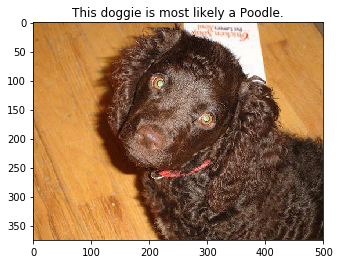

In [63]:
dog_breed_detector_VGG19("images/American_water_spaniel_00648.jpg")

---
<a id='step7'></a>
## Step 7: Teste seu algoritmo

Nesta seção, você levará seu novo algoritmo para dar uma volta! Que tipo de cão o algoritmo pensa que o __you__ se parece? Se você tem um cachorro, ele prevê a raça do seu cão com precisão? Se você tem um gato, ele pensa erroneamente que seu gato é um cachorro?

### (IMPLEMENTAÇÃO) Teste seu algoritmo em imagens de exemplo!

Teste seu algoritmo com pelo menos seis imagens no seu computador. Sinta-se à vontade para usar qualquer imagem que desejar. Use pelo menos duas imagens humanas e duas de cachorro. 

__Questão 6:__ A saída é melhor do que você esperava :)? Ou pior: (? Fornecer pelo menos três possíveis pontos de melhoria para o seu algoritmo.

__Resposta:__ 

In [64]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
def  dog_breed_detector_from_scratch(img_path):
    img = mpimg.imread(img_path)
    _ = plt.imshow(img)
    if face_detector(img_path):
        tensor = path_to_tensor(img_path).astype('float32')/255
        index = np.argmax(model.predict(tensor))
        plt.title("The human in the image most resembles a %s." % dog_names[index]);
    elif dog_detector(img_path):
        tensor = path_to_tensor(img_path).astype('float32')/255
        index = np.argmax(model.predict(tensor))
        plt.title("This doggie is most likely a %s." % dog_names[index]);
    else:
        plt.title("Please input an image of either a human or a dog!")
    plt.show()
    return

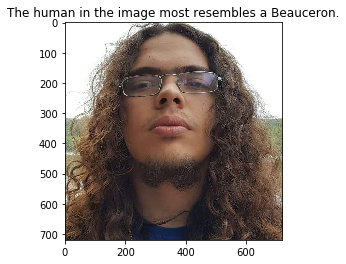

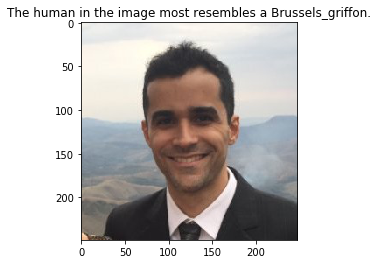

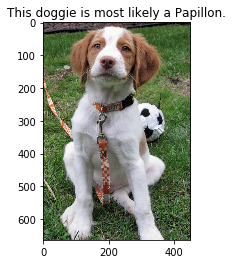

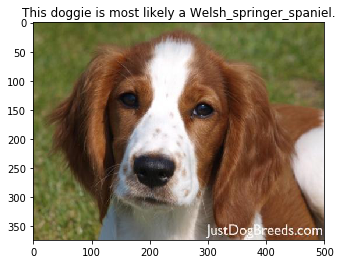

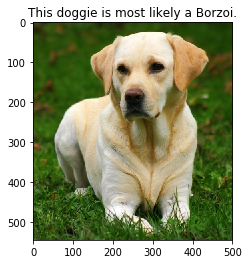

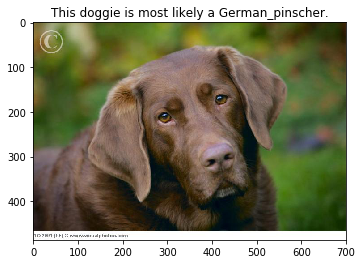

In [65]:
examples = ["images/foto_igor.jpeg","images/Avatar_Eduardo_Oliveira.jpg", "images/Brittany_02625.jpg","images/Welsh_springer_spaniel_08203.jpg","images/Labrador_retriever_06457.jpg","images/Labrador_retriever_06455.jpg"]
for i in range (0,6):
    dog_breed_detector_from_scratch(examples[i])